In [1]:
%pylab inline
import pandas as pd
from pandas.api.types import is_categorical_dtype

from pyro.contrib.brm import defm, makedesc
from pyro.contrib.brm.design import metadata_from_df, metadata_from_cols, RealValued, Categorical, makedata
from pyro.contrib.brm.family import Normal, HalfCauchy
from pyro.contrib.brm.formula import parse
from pyro.contrib.brm.model import model_repr
from pyro.contrib.brm.fit import fitted, Fit
from pyro.contrib.brm.priors import Prior
from pyro.contrib.brm.pyro_backend import backend as pyro_backend

from oed import *

Populating the interactive namespace from numpy and matplotlib


## Defining the model

Here we define the model and design space using existing brmp functionality. (We could of course provide a nicer interface.)

In [2]:
formula = parse('y ~ 1 + x1 + x2')

metadata = metadata_from_cols([
    RealValued('y'),
    Categorical('x1', ['a','b']),
    Categorical('x2', ['c','d']),
])

response = Normal
priors = [Prior(('b',), Normal(0.,1.)), Prior(('resp','sigma'), HalfCauchy(.1))]

# Boiler plate.
model_desc = makedesc(formula, metadata, response, priors)

The design space for this model is:

In [3]:
metadata.levels(design_space_cols(formula, metadata))

[('a', 'c'), ('a', 'd'), ('b', 'c'), ('b', 'd')]

It's not currently very easy to start from the prior, so instead we start from a single dummy result/observation. (In this case corresponsing to running `('a','c')` and obtaining result `0.0`.

In [4]:
data_so_far = pd.DataFrame(dict(
    y=[0.],
    x1=pd.Categorical(['a']),
    x2=pd.Categorical(['c']),
))
data_so_far

,y,x1,x2
0,0.0,a,c


## Computing the next design

Here we estimate the information gain for all designs. This current using a separate ANN for each design.

In [5]:
design, dstar, eigs, plot_data = next_trial(formula, model_desc, data_so_far, metadata)
eigs

warmup:   8%|▊         | 6/75 [00:00<00:01, 53.60it/s, step size=2.83e-01, acc. prob=0.644]

sample: 100%|██████████| 75/75 [00:01<00:00, 59.26it/s, step size=3.39e-01, acc. prob=0.235]


100 | 2.3399999141693115
200 | 2.3399999141693115
300 | 2.3399999141693115
400 | 2.3399999141693115
500 | 2.3399999141693115
600 | 2.3399999141693115
700 | 2.3399999141693115
800 | 2.3399999141693115
900 | 2.3399999141693115
1000 | 2.3399999141693115
eig: 2.3399999141693115
all zero would yield: 1.340000033378601
100 | 2.834780216217041
200 | 2.83952260017395
300 | 2.8398401737213135
400 | 2.8399181365966797
500 | 2.8399498462677
600 | 2.8399658203125
700 | 2.839975595474243
800 | 2.8399817943573
900 | 2.8399853706359863
1000 | 2.8399884700775146
eig: 2.8399884700775146
all zero would yield: 1.340000033378601
100 | 2.8183586597442627
200 | 2.8195056915283203
300 | 2.819766044616699
400 | 2.8598833084106445
500 | 2.8599228858947754
600 | 2.8599436283111572
700 | 2.859956979751587
800 | 2.8599658012390137
900 | 2.8599724769592285
1000 | 2.8599774837493896
eig: 2.8599774837493896
all zero would yield: 1.340000033378601
100 | 2.3399999141693115
200 | 2.3399999141693115
300 | 2.339999914169

[2.3399999141693115,
 2.8399884700775146,
 2.8599774837493896,
 2.3399999141693115]

For each design/coefficient pair, this plot shows the target ($\theta \in [-0.5,0.5]$) and the function learned by the corresponing ANN. (It took a bit of fiddling with priors and `eps` before there was anything interesting for the ANN to learn.)

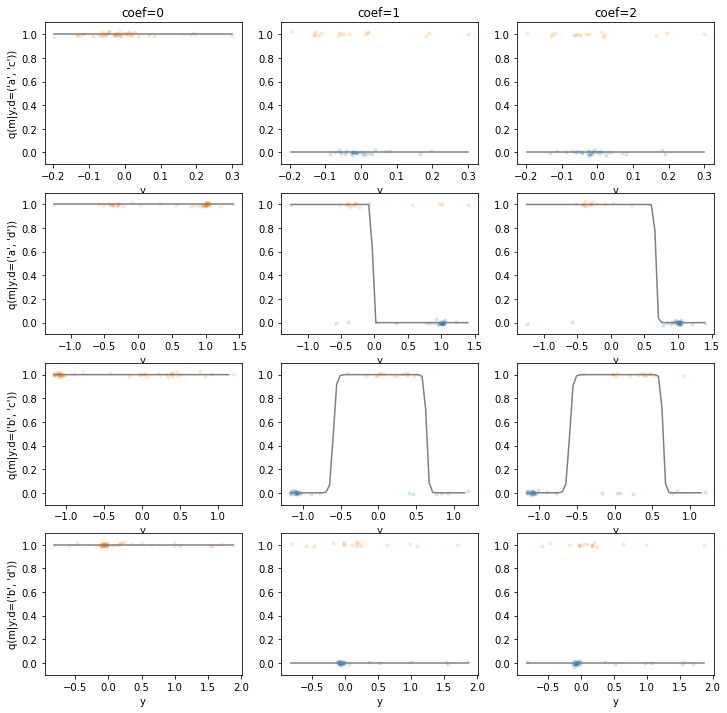

In [6]:
make_training_data_plot(plot_data)

We could now run the experiment, extend `data_so_far`, and get the next trial like so:

In [7]:
data_so_far2 = extend_df_with_result(formula, metadata, data_so_far, design, result=2.0)
data_so_far2

,y,x1,x2
0,0.0,a,c
0,2.0,b,c


In [8]:
#design, dstar, eigs, plot_data = next_trial(formula, model_desc, data_so_far2, meta)